<div class="alert alert-success">
    <h1 align="center">Lesson 4: Object Detection - YOLO</h1>
    <h3 align="center"><a href="http://www.snrazavi.ir">Seyed Naser RAZAVI</a></h3>
</div>

## Introduction

Get detections on a single pass.
1. Resize the input image (e.g., 448x448).
2. Run Convolutional Network to get detections.
3. Filter the output by a Non-max supression algorithm (to remove multiple detections of the same object)

<img src='imgs/yolo-steps.png' width='90%' />

## Tiny YOLO

Architecture (training phase):
- Input size: `448` x `448`
- Nine Convolutional layers with leaky ReLU.
- Six max pooling layers.
- Backbone feature map: `7` x `7` (`7` x `64` = `448`)


<h6>Tiny YOLO output</h6>

Output size: `30` x `7` x `7`:
- Two bounding box definitions, containing `x`, `y`, `height`, `width` and`confidence`. (`2` x `5`)
- Class probabilities, relevant if only object confidence is high enough. (`20`)

<img src='imgs/TinyYolo-Output.png' width='95%'/>

<h6>Box probabilities:</h6>

If there is an object in a cell, we decide which object by finding the **biggest probability**.

<img src='imgs/CellClass.png' width='30%'/>

<h6>Non-Max Supreesion:</h6>

- An object may be detected several times by different boxes (grid cells).
- So, we need to use non-max supression to filter the results.
- Final detections are obtained by using **thresholding** and **non-max supression**.

<img src='imgs/FilterResults.png' width='90%'/>

<!-- ```python
def non_max_suppress(conf, xy_min, xy_max, threshold=.4):
    _, _, classes = conf.shape
    boxes = [(_conf, _xy_min, _xy_max) for _conf, _xy_min, _xy_max in zip(conf.reshape(-1, classes), xy_min.reshape(-1, 2), xy_max.reshape(-1, 2))]

    # Iterate each class
    for c in range(classes):
        # Sort boxes according to their prob for class c
        boxes.sort(key=lambda box: box[0][c], reverse=True)
        # Iterate each box
        for i in range(len(boxes) - 1):
            box_i = boxes[i]
            if box_i[0][c] == 0:
                continue
            for box_j in boxes[i + 1:]:
                # Take iou threshold into account
                if iou(box_i[1], box_i[2], box_j[1], box_j[2]) >= threshold:
                    box_j[0][c] = 0
    return boxes
``` -->

## Training phase

- **Matching phase:** find which cell is near the center of the BB of the ground truth.
- By using **IoU**, find which of the two bounding boxes overlaps more with the ground truth.

### Other training details

- Pre-trained on Imagenet.
- Lot's of augmentations:
 - Random scale and translations (up to 20% of the original image size)
 - Color exposure/saturation.
- SGD for optimization. (momentum 0.9)
- 135 epochs with batch size of 64.
- Evaluation on Pascal VOC.

## Loss function

Yolo loss function consists of three main parts:
- Location loss (x, y, w, h)
- Confidence loss (objectness)
- Classification loss


<img src='imgs/LossYOlo.png' width='70%'/>

### Intersection over Union (IoU)

A measure to compute the **overlap** between two bounding boxes. (always between `0` and `1`)

<img src='imgs/IoU.png' width='80%'/>

<!-- ```python
def iou(b1, b2):
    # determine the coordinates of the intersection rectangle
    # each box is a list of four numbers like [x1, y1, x2, y2]
    xA = max(b1[0], b2[0])
    yA = max(b1[1], b2[1])
    xB = min(b1[2], b2[2])
    yB = min(b1[3], b2[3])
    
    # compute the area of intersection
    area_intersect = (xB - xA + 1) * (yB - yA + 1)
    
    # Calculate area of the two boxes
    area_b1 = (b1[2] - b1[0] + 1) * (b1[3] - b1[1] + 1)
    area_b2 = (b2[2] - b2[0] + 1) * (b2[3] - b2[1] + 1)
    
    # compute and return the intersection over union
    return area_intersect / float(area_b1 + area_b2 - area_intersect)
``` -->

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Implementation

In [36]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import time
import warnings
from glob import glob
from PIL import Image
from collections import OrderedDict

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2              # برای پردازش تصاویر (اختیاری، چون ultralytics از PIL استفاده می‌کند)
import numpy as np      # برای عملیات آرایه‌ای
import matplotlib.pyplot as plt  # برای نمایش نتایج
from PIL import Image   # برای کار با تصاویر (مورد استفاده در YOLOv8)
import torch            # فقط اگر بخواهید از PyTorch برای پردازش‌های جانبی استفاده کنید
import xml.etree.ElementTree as ET
from glob import glob  # اگر نیازی به جستجوی فایل‌ها نباشد، می‌توان حذف کرد
import sys  # اگر استفاده نشود، می‌توان حذف کرد
import json  # مگر اینکه برای پردازش خروجی‌های JSON مدل نیاز باشد
import time  # فقط اگر زمان‌سنجی دستی انجام دهید
import cv2
from google.colab.patches import cv2_imshow


use_gpu = torch.cuda.is_available()
warnings.filterwarnings("ignore")

In [3]:
!pip install ultralytics
from ultralytics import YOLO

In [6]:
!pip install roboflow
from roboflow import Roboflow

In [7]:
sys.path.append('/content/drive/MyDrive/Thesis/Projects/Yolo-Steps/')

from yolo_loss import YoloLoss
from utils import *

Dataset

In [8]:
from roboflow import Roboflow
rf = Roboflow(api_key="4B97i6P7vkstoPXiG4du")
project = rf.workspace("object-y2str").project("2500-person-animal-car")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to 2500-person-animal-car-1 in yolov8:: 100%|██████████| 15010/15010 [00:02<00:00, 7478.72it/s]


In [44]:
import os

# گرفتن مسیر دیتاست
dataset_path = dataset.location  # این مسیر به صورت string ذخیره شده

# نمایش مسیرهای زیرپوشه‌ها
for subdir in ["train", "valid", "test"]:
    images_path = os.path.join(dataset_path, subdir, "images")
    labels_path = os.path.join(dataset_path, subdir, "labels")
    print(f"{subdir} images path: {images_path}")
    print(f"{subdir} labels path: {labels_path}")


train images path: /content/2500-person-animal-car-1/train/images
train labels path: /content/2500-person-animal-car-1/train/labels
valid images path: /content/2500-person-animal-car-1/valid/images
valid labels path: /content/2500-person-animal-car-1/valid/labels
test images path: /content/2500-person-animal-car-1/test/images
test labels path: /content/2500-person-animal-car-1/test/labels


In [41]:
# حالت‌های مختلف بارگذاری مدل:
model = YOLO("yolov8n.pt")  # مدل پیش‌آموخته (nano)
# model = YOLO("yolov8s.pt")  # مدل small
# model = YOLO("custom_model.pt")  # مدل آموزش‌دیدهٔ خودتان

In [42]:
# مسیر پوشه تصاویر تست
test_images_path = "2500-person-animal-car-1/test/images"

# گرفتن لیست تصاویر
image_files = os.listdir(test_images_path)

# انتخاب تصادفی یک فایل عکس
random_image = random.choice(image_files)

# مسیر کامل عکس برای پیش‌بینی
image_path = os.path.join(test_images_path, random_image)

# پیش‌بینی با مدل YOLO
results = model.predict(
    source=image_path,
    conf=0.5,
    iou=0.45,
    save=True,
    show=True,
)

print("Random image used:", image_path)



image 1/1 /content/2500-person-animal-car-1/test/images/0569e4df2cc41210_jpg.rf.514d1fa9f79c7f725f0c9c92f85041f2.jpg: 640x640 5 cars, 1 bus, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3
Random image used: 2500-person-animal-car-1/test/images/0569e4df2cc41210_jpg.rf.514d1fa9f79c7f725f0c9c92f85041f2.jpg


کلاس: bus, اطمینان: 0.78, مختصات: (228,96)-(415,223)
کلاس: car, اطمینان: 0.73, مختصات: (128,265)-(415,415)
کلاس: car, اطمینان: 0.70, مختصات: (88,94)-(110,113)
کلاس: car, اطمینان: 0.68, مختصات: (210,85)-(272,128)
کلاس: car, اطمینان: 0.67, مختصات: (159,99)-(180,117)
کلاس: car, اطمینان: 0.66, مختصات: (180,89)-(214,119)


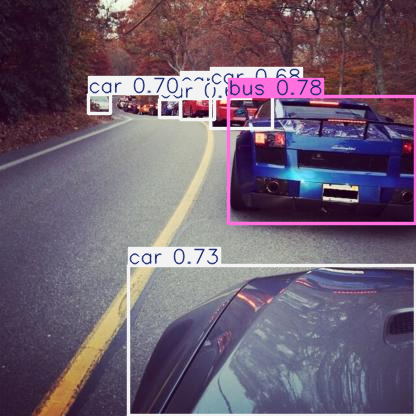

In [43]:
# نمایش نتایج
for result in results:
    # 1. نمایش اطلاعات در کنسول
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())  # تبدیل به اعداد صحیح
        conf = box.conf.item()
        cls_id = int(box.cls.item())
        cls_name = model.names[cls_id]
        print(f"کلاس: {cls_name}, اطمینان: {conf:.2f}, مختصات: ({x1},{y1})-({x2},{y2})")

    # 2. نمایش تصویر با جعبه‌ها
    output_image = result.plot()  # رسم خودکار جعبه‌ها و لیبل‌ها

    # تنظیم سایز پنجره
    height, width = output_image.shape[:2]
    max_size = 800  # حداکثر سایز برای نمایش
    if max(height, width) > max_size:
        scale = max_size / max(height, width)
        output_image = cv2.resize(output_image, (int(width*scale), int(height*scale)))

    # نمایش تصویر
    cv2_imshow(output_image)
    # 3. ذخیره تصویر
    cv2.imwrite("output.jpg", output_image)

In [49]:
import os

# گرفتن مسیر دیتاست
dataset_path = dataset.location  # این مسیر به صورت string ذخیره شده
print(dataset_path)
# نمایش مسیرهای زیرپوشه‌ها
for subdir in ["train", "valid", "test"]:
    images_path = os.path.join(dataset_path, subdir, "images")
    labels_path = os.path.join(dataset_path, subdir, "labels")
    print(f"{subdir} images path: {images_path}")
    print(f"{subdir} labels path: {labels_path}")

/content/2500-person-animal-car-1
train images path: /content/2500-person-animal-car-1/train/images
train labels path: /content/2500-person-animal-car-1/train/labels
valid images path: /content/2500-person-animal-car-1/valid/images
valid labels path: /content/2500-person-animal-car-1/valid/labels
test images path: /content/2500-person-animal-car-1/test/images
test labels path: /content/2500-person-animal-car-1/test/labels


In [50]:
import yaml

# مسیر فایل yaml در دیتاست
yaml_path = "/content/2500-person-animal-car-1/data.yaml"

# خوندن و چاپ لیست کلاس‌ها
with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)
    class_names = data['names']
    print("کلاس‌ها:")
    for idx, name in enumerate(class_names):
        print(f"{idx}: {name}")

کلاس‌ها:
0: Animal
1: Car
2: Person


In [52]:
# ساخت فایل پیکربندی داده‌ها (data.yaml)
data_yaml = """
train: /content/2500-person-animal-car-1/train/images  # مسیر تصاویر آموزشی
val: /content/2500-person-animal-car-1/valid/images     # مسیر تصاویر اعتبارسنجی
names:
  0: Animal  # لیست کلاس‌ها
  1: Car
  2: Person
"""

with open("data.yaml", "w") as f:
    f.write(data_yaml)

# بررسی در دسترس بودن GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"در حال استفاده از: {device}")

# آموزش مدل
model.train(
    data="data.yaml",  # فایل پیکربندی
    epochs=10,       # تعداد دوره‌ها
    batch=16,         # اندازه بچ
    imgsz=640,        # اندازه تصویر
    lr0=0.01,         # نرخ یادگیری اولیه
    device=device,
)

در حال استفاده از: cuda:0
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretr

train: Scanning /content/2500-person-animal-car-1/train/labels.cache... 6374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6374/6374 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 252.5±29.4 MB/s, size: 26.3 KB)


val: Scanning /content/2500-person-animal-car-1/valid/labels.cache... 750 images, 0 backgrounds, 0 corrupt: 100%|██████████| 750/750 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.92G      1.822      2.652      1.839         14        640: 100%|██████████| 399/399 [01:58<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.83it/s]


                   all        750       2292      0.346      0.312      0.265      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.16G      1.702      2.268      1.749         16        640: 100%|██████████| 399/399 [01:46<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.22it/s]


                   all        750       2292      0.458      0.319      0.316      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.16G      1.658      2.132      1.731         28        640: 100%|██████████| 399/399 [01:45<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.20it/s]


                   all        750       2292      0.393      0.382      0.326      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.16G      1.617      2.017      1.692         19        640: 100%|██████████| 399/399 [01:47<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.90it/s]


                   all        750       2292      0.472      0.365       0.37      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.17G      1.557      1.908      1.644         15        640: 100%|██████████| 399/399 [01:48<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.93it/s]


                   all        750       2292      0.473      0.417      0.408      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.19G      1.504      1.817      1.612         27        640: 100%|██████████| 399/399 [01:48<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.67it/s]

                   all        750       2292      0.523      0.435       0.43      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10       3.2G      1.464       1.73      1.576          8        640: 100%|██████████| 399/399 [01:48<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.20it/s]


                   all        750       2292      0.553      0.434      0.457      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.22G      1.429      1.669      1.542          9        640: 100%|██████████| 399/399 [01:47<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.24it/s]


                   all        750       2292      0.513      0.459      0.449      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.22G      1.397      1.594       1.51         11        640: 100%|██████████| 399/399 [01:48<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.98it/s]


                   all        750       2292      0.536      0.483      0.486      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.22G      1.362      1.538      1.484         29        640: 100%|██████████| 399/399 [01:49<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.93it/s]


                   all        750       2292      0.578      0.479      0.496      0.303

10 epochs completed in 0.323 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:10<00:00,  2.22it/s]


                   all        750       2292      0.578       0.48      0.496      0.303
                Animal        246        482      0.549      0.421       0.45       0.27
                   Car        255        680      0.684       0.61      0.648      0.441
                Person        249       1130      0.499      0.409      0.388      0.197
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7db76e1d3990>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [55]:
model = YOLO('runs/detect/train3/weights/last.pt')  # بارگذاری مدل ذخیره شده
model.train(
    data="data.yaml",
    epochs=20,       # تعداد کل اپوک
    batch=16,
    imgsz=640,
    lr0=0.01,
    device="0",
)



Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/train3/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrai

train: Scanning /content/2500-person-animal-car-1/train/labels.cache... 6374 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6374/6374 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 297.5±105.8 MB/s, size: 26.3 KB)


val: Scanning /content/2500-person-animal-car-1/valid/labels.cache... 750 images, 0 backgrounds, 0 corrupt: 100%|██████████| 750/750 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.27G      1.443      1.738       1.53         16        640: 100%|██████████| 399/399 [02:08<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.27it/s]


                   all        750       2292      0.548      0.461      0.464      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.27G      1.433      1.774      1.534         46        640: 100%|██████████| 399/399 [01:57<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.66it/s]


                   all        750       2292      0.545      0.439      0.439      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.27G      1.459      1.827      1.546         24        640: 100%|██████████| 399/399 [01:58<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.95it/s]


                   all        750       2292      0.483      0.421      0.409      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.27G      1.453      1.817      1.537         15        640: 100%|██████████| 399/399 [01:54<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.01it/s]


                   all        750       2292      0.485      0.406      0.398      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.27G      1.432      1.793      1.525         12        640: 100%|██████████| 399/399 [01:54<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.74it/s]

                   all        750       2292      0.519      0.424      0.425       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.27G      1.422      1.754      1.515         29        640: 100%|██████████| 399/399 [01:56<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.62it/s]


                   all        750       2292      0.505      0.433      0.418      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.27G        1.4      1.739      1.507         17        640: 100%|██████████| 399/399 [01:54<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.27it/s]


                   all        750       2292      0.542      0.438      0.447      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.27G      1.377        1.7       1.49         16        640: 100%|██████████| 399/399 [01:54<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.85it/s]


                   all        750       2292      0.556      0.438      0.454      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.27G      1.372      1.674      1.474         25        640: 100%|██████████| 399/399 [01:54<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.28it/s]


                   all        750       2292      0.576      0.428      0.455      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.27G      1.353      1.638      1.466         22        640: 100%|██████████| 399/399 [01:58<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.13it/s]


                   all        750       2292      0.557      0.463      0.472      0.284
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.27G       1.38       1.55      1.505         12        640: 100%|██████████| 399/399 [01:54<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.69it/s]


                   all        750       2292      0.527      0.467      0.463      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.27G      1.363      1.517       1.49         11        640: 100%|██████████| 399/399 [01:52<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.17it/s]


                   all        750       2292      0.558      0.474      0.491      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.27G      1.343      1.474      1.469         12        640: 100%|██████████| 399/399 [01:47<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.36it/s]


                   all        750       2292      0.574      0.473       0.49      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.27G      1.322      1.431      1.454          9        640: 100%|██████████| 399/399 [01:51<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.98it/s]


                   all        750       2292      0.568      0.487      0.503      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.27G      1.308      1.392      1.437          9        640: 100%|██████████| 399/399 [01:52<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.24it/s]

                   all        750       2292      0.556      0.483      0.491      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.27G      1.287      1.378      1.423         12        640: 100%|██████████| 399/399 [01:49<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.96it/s]

                   all        750       2292      0.561      0.497      0.516      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.27G      1.283       1.34      1.415         15        640: 100%|██████████| 399/399 [01:51<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.89it/s]


                   all        750       2292      0.588      0.492      0.516      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.27G      1.268      1.313      1.402         25        640: 100%|██████████| 399/399 [01:53<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.17it/s]

                   all        750       2292      0.593      0.485      0.522      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.27G      1.247      1.275      1.385          9        640: 100%|██████████| 399/399 [01:52<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.64it/s]


                   all        750       2292       0.59      0.498      0.532      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.29G      1.241      1.261      1.383         13        640: 100%|██████████| 399/399 [01:54<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.15it/s]

                   all        750       2292      0.597      0.503      0.532      0.327



20 epochs completed in 0.679 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.95it/s]


                   all        750       2292        0.6      0.502      0.532      0.327
                Animal        246        482      0.543      0.471      0.498      0.296
                   Car        255        680      0.717      0.621      0.672      0.462
                Person        249       1130       0.54      0.416      0.425      0.223
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7db782354710>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [56]:
# ذخیره مدل در فرمت‌های مختلف
model.export(format="onnx")  # ONNX (برای TensorRT, OpenVINO)
# model.export(format="engine")  # TensorRT
# model.export(format="torchscript")  # TorchScript

Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/train5/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.46', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 201.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.2/146.2 kB 214.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 166.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 155.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 127.3 MB/s eta 0:00:00

requirements: Auto

'runs/detect/train5/weights/best.onnx'

In [57]:
# ارزیابی روی داده Validation
metrics = model.val()  # محاسبه mAP, Precision, Recall
print(metrics.box.map)  # mAP50-95


Ultralytics 8.3.136 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 713.7±208.8 MB/s, size: 27.8 KB)


val: Scanning /content/2500-person-animal-car-1/valid/labels.cache... 750 images, 0 backgrounds, 0 corrupt: 100%|██████████| 750/750 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:17<00:00,  2.62it/s]


                   all        750       2292      0.598      0.506      0.533      0.327
                Animal        246        482      0.541      0.473      0.499      0.296
                   Car        255        680      0.713      0.622      0.672      0.463
                Person        249       1130      0.539      0.423      0.427      0.222
Speed: 1.5ms preprocess, 5.2ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/train52
0.327137790241331



0: 640x640 1 car, 9.7ms
Speed: 2.6ms preprocess, 9.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


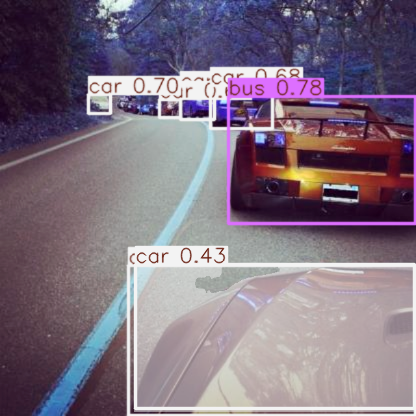

In [67]:
from ultralytics import YOLO
import cv2

# مدل سگمنتیشن رو بارگذاری کن
seg_model = YOLO("yolov8n-seg.pt")

# پیش‌بینی روی تصویر (output_image یا مسیر تصویر)
results = seg_model.predict(source=output_image)

# تصویر خروجی با ماسک و کادرها
output_with_mask = results[0].plot()

# تبدیل رنگ RGB به BGR برای OpenCV
output_bgr = cv2.cvtColor(output_with_mask, cv2.COLOR_RGB2BGR)

from google.colab.patches import cv2_imshow
cv2_imshow(output_bgr)
